In [1]:
import plotly.graph_objs as go
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 0.6

## Хеджирование Uniswap V3 позиций с помощью опционов

В этой статье мы рассмотрим, как с помощью опционов можно хеджировать юнисвоповские позиции 

#### Содержание статьи
- Небольшой remainder:
    - Uniswap V3 позиция
    - Риск-профиль провайдера ликвидности
- Что такое опцион
- Профиль Put опциона
- Совмещаем Uniswap V3 позицию и купленный Put опцион
- Итоги

#### Вводные термины:
- **Базовый актив** - это рассматриваемый актив, в нашем случае токен
- **Хеджировать** - значит защититься от риска. Когда юзер держит рисковый актив (например, эфир, открытая позиция на юнисвопе и т.п.), его стоимость портфеля зависит от цены актива. Захеджировать позицию - значит сделать так, чтобы позиция стала менее зависимой от рискового фактора (в данном случае цены актива)

### Uniswap V3 позиция

Давайте вспомним, как работает Uniswap V3. Провайдеры ликвидности выставляют желаемый price range, в котором будут использоваться их предоставляемые токены, получая комиссии за своп. Чем уже диапазон, тем больше комиссий она будет зарабатывать при каждом свопе. Одна при узком диапазоне цена быстрее выйдет из него, и позиция уже не будет зарабатывать ничего.

Когда кто-то обменивает одни токены на другие, например, USDC на WETH, в пуле становится больше долларов и меньше эфиров. То есть кол-во подорожавшего актива стало меньше, но цена стала чуть больше, и так в каждой Uniswap V3 позиции, которая была активной на момент свопа. Соответственно суммарная стоимость портфеля у провайдера ликвидности поменялась.


### Риск-профиль провайдера ликвидности

Рассмотрим как зависит стоимость позиции провайдера ликвидности в зависимости от цены эфира:

In [2]:
def get_liquidity_from_token0(x0, p0, pb):
    """
        This function returns liquidity from token0 amount
    """
    return x0 / (1 / (p0)**0.5 - 1 / (pb)**0.5)

def get_token1_amount_from_upper_price(L, pa, pb):
    """
        This function returns the amount of token1 when price crosses upper price
    """
    return L * (pb**0.5 - pa**0.5)

def get_token0_amount_from_lower_price(L, pa, pb):
    """
        This function returns the amount of token0 when price drops lower than lower price
    """
    return L * (1 / (pa**0.5) - 1 / (pb**0.5))


def uniswap_v3_total_value(k, L, p0, pa, pb):
    """
        This function returns the total value of uniswap v3 position depending on price and position params
    """
    
    if p0*k >= pa and p0*k <= pb:
        return 2 * L * (p0*k) ** 0.5 - L * ((pa)**0.5 + (p0 * k) / ((pb) ** 0.5))
    
    elif p0*k > pb:
        return get_token1_amount_from_upper_price(L, pa, pb)
        
    elif p0*k < pa:
        return get_token0_amount_from_lower_price(L, pa, pb) * p0 * k

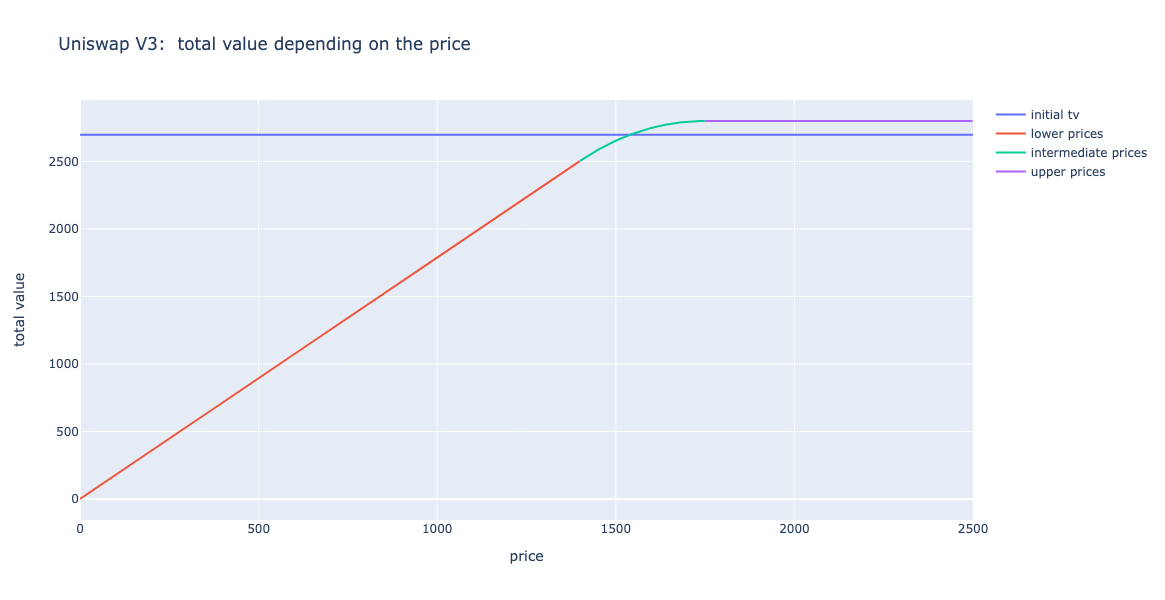

In [51]:
prices = np.array([price for price in range(0, 2501)])
price0 = 1540
pa = 1400
pb = 1750
x0 = 1 # e.g. ethers

liquidity = get_liquidity_from_token0(x0, price0, pb)

lower_prices = np.array([price for price in range(0, pa)])

uniswap_v3_tvs_lower_prices = np.array([uniswap_v3_total_value(k=price / price0, 
                                                  L=liquidity, 
                                                  p0=price0, 
                                                  pa=pa, 
                                                  pb=pb) for price in lower_prices])

intermediate_prices = np.array([price for price in range(pa, pb)])

uniswap_v3_tvs_intermediate_prices = np.array([uniswap_v3_total_value(k=price / price0, 
                                                  L=liquidity, 
                                                  p0=price0, 
                                                  pa=pa, 
                                                  pb=pb) for price in intermediate_prices])

# calculating initial total value
initial_tvs = np.array([uniswap_v3_total_value(k=1, 
                                      L=liquidity, 
                                      p0=price0, 
                                      pa=pa, 
                                      pb=pb) for price in prices])

upper_prices = np.array([price for price in range(pb, max(prices))])

uniswap_v3_tvs_upper_prices = np.array([uniswap_v3_total_value(k=price / price0, 
                                                  L=liquidity, 
                                                  p0=price0, 
                                                  pa=pa, 
                                                  pb=pb) for price in upper_prices])

fig = go.Figure()
fig.add_trace(go.Scatter(x=prices, y=initial_tvs, mode='lines', name='initial tv'))
fig.add_trace(go.Scatter(x=lower_prices, y=uniswap_v3_tvs_lower_prices , name='lower prices'))
fig.add_trace(go.Scatter(x=intermediate_prices, y=uniswap_v3_tvs_intermediate_prices, name='intermediate prices'))
fig.add_trace(go.Scatter(x=upper_prices, y=uniswap_v3_tvs_upper_prices, name='upper prices'))

fig.update_layout(title='Uniswap V3:  total value depending on the price', xaxis_title='price', yaxis_title='total value', width=850, height=600)
fig.show()


#### В чем проблема такой позиции?

Проблема в том, что если цена пойдёт вниз, то провайдер ликвидности будет фиксировать всё больше и больше убытка. Сначала, из-за кривизны Uniswap V3 позиции (пока цена находится в диапазоне), лосс будет не такой сильный, но по мере движения цены вниз убыток будет всё сильнее возрастать.

Это значит, что **у провайдера ликвидности открытый риск по цене базового актива**. 


#### Что можно сделать?

Можно купить опцион, и благодаря нему провайдер ликвидности не будет так сильно зависим от цены базового актива.

#### Что такое опцион?

**Опцион** - это контракт, который дает право (но не обязательство) купить/продать базовый актив в заранее оговоренный момент времени по заранее оговорённой цене.



Здесь важно, что у покупателя есть право, но не обязательство. То есть он в момент экспирации (истечения) опциона может и не исполнять этот опцион. Например, если этот опцион будет для него невыгоден.

В данной статьей будем рассматривать только европейские опционы, то есть те, которые можно исполнить только в момент истечения самого опциона.

Опционы бывают двух типов: первый тип дает право на покупку, второй тип - право на продажу (в фиксированный момент времени по фиксированной цене).

В нашем случае, чтобы захеджировать провайдера ликвидности, нам нужен опцион, который дает право на продажу.

Опцион, который дает право на продажу (такой опцион называется **Put option**):

### Как посчитать выплату по опциону

Выплата - то есть сколько мы заработаем/потеряем, если купим данный опцион.


Выплата по европейскому **put**-опциону на экспирации определяется формулой:

$$Payoff = max(0, K - S_T) - P_0$$

$S_T$ - цена базового актива на момент экспирации опциона <br/>
$K$ - страйк опциона <br/>
$P_0$ - цена put-опциона на момент покупки ($t=0$)

#### Выплата в зависимости от цены на момент исполнения опциона будет выглядеть так:


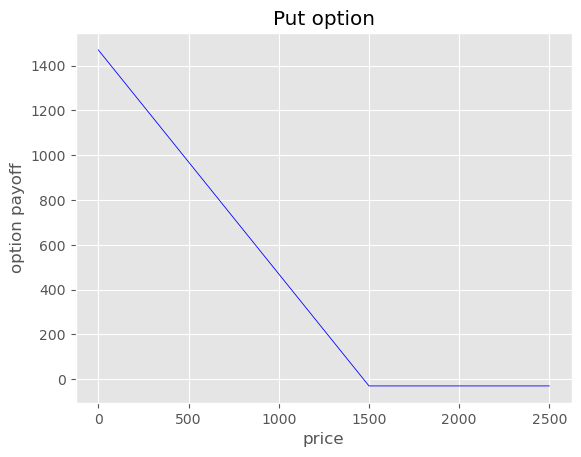

In [84]:
K = 1500 # strike price

P0 = 30

prices = np.array([price for price in range(0, 2500)])
puts = [max(0, K - price) - P0 for price in prices]

plt.plot(prices, puts, 'b')
plt.title('Put option')
plt.xlabel('price')
plt.ylabel('option payoff')
plt.show()


### Что здесь примечательного? 

Такой опцион дает положительную выплату при падении цены базового актива, а в рассматриваемой нами Uniswap V3 позиции мы теряем деньги при движении цены вниз.

#### Поэтому давайте "купим" такой опцион, то есть сложим два графика и посмотрим что будет:

In [85]:
univ3_tvs = list(uniswap_v3_tvs_lower_prices) + list(uniswap_v3_tvs_intermediate_prices) + list(uniswap_v3_tvs_upper_prices)

new_univ3_tvs = np.array(univ3_tvs) + 1.8 * np.array(puts)

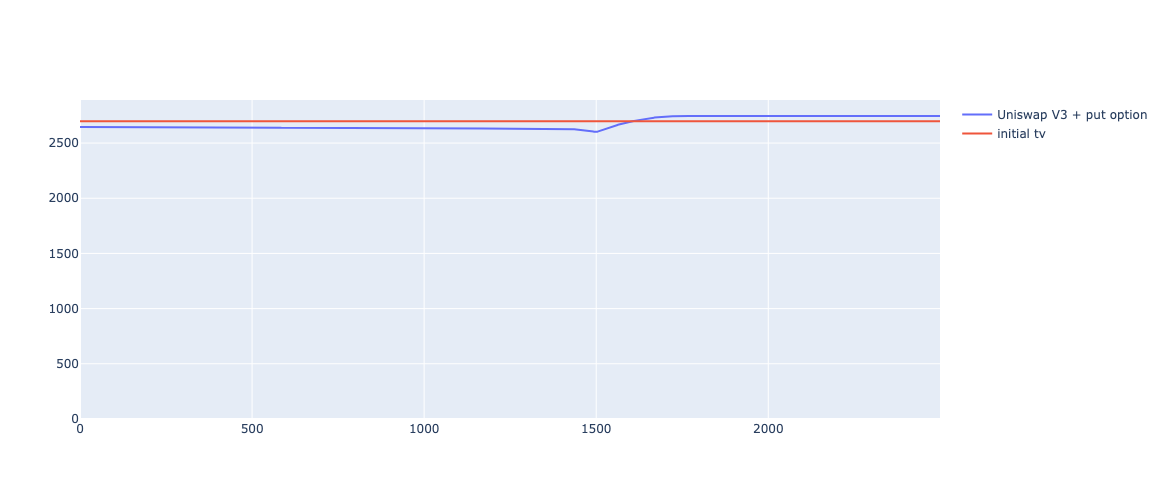

In [86]:
fig = go.Figure()
fig.update_layout(
    autosize=False,
    width=900,
    height=500)
fig.add_trace(go.Scatter(x=prices, y=new_univ3_tvs, mode='lines', name='Uniswap V3 + put option'))
fig.add_trace(go.Scatter(x=prices, y=initial_tvs, mode='lines', name='initial tv'))

fig.add_hline(y=-0.3, line_color="rgba(0,0,0,0)")


В примере выше мы купили не один опцион, а 1.8 чтобы в сумме Uniswap V3 позиция и опцион давали около-горизонтальный график.

### Важно:
- В данном примере  стоимость опциона была взята "наобум", чисто чтобы показать как хеджирование опционами работает.

### Итоги